# Demo - Velocity Gradient Technique

This is a demo showing how Velocity Gradient work our simulation data, with $Ma=0.22$ and $Ms=7.31$

In this demo, we will use Velocity Centroid Gradient (VCG) to calculate the magnetic field.

**Step1. Import the library**. 
1. Install packages `HDF5, PyCall, PyPlot`. 
```
Pkg.add("HDF5")
Pkg.add("PyCall")
Pkg.add("PyPlot")
```
2. Copy the `VGLib.jl` to working directory

In [ ]:
include("./VGLib.jl");
using VGLib,HDF5,PyCall,PyPlot
@pyimport numpy as np

**Step2. Read the data**

We chose our simulation cube `run-0-ppv.h5` for our experiement, but you can select your HDF5 cube

In [ ]:
dataname= "run-0-ppv.h5";

In [ ]:
f       = h5open(dataname,"r");

In [2]:
ppv_d   = read( f, "PPV");    # PPV cube
v_ran   = read( f, "vrange"); # velocity range within the x-axis 
Q       = read( f, "Q");      # Q (Stokes Parameter)
U       = read( f, "U");      # U (Stokes Parameter)

792x792 Array{Float64,2}:
 -58148.3  -56641.2  -54896.9  -52777.5  …  -62283.3  -60950.9  -59574.3
 -58366.8  -56847.3  -55151.6  -53135.9     -62709.3  -61351.0  -59920.3
 -58674.3  -57087.3  -55360.6  -53377.3     -63184.0  -61855.4  -60414.4
 -59118.1  -57433.6  -55602.3  -53553.0     -63661.4  -62433.3  -61026.5
 -59658.6  -57867.2  -55816.8  -53586.7     -64099.6  -62994.7  -61629.6
 -60035.8  -58211.9  -56118.0  -53768.3  …  -64419.9  -63397.5  -62086.6
 -60389.5  -58587.5  -56438.1  -53959.1     -64556.9  -63588.2  -62367.2
 -60526.3  -58717.6  -56538.5  -54024.2     -64602.4  -63668.3  -62472.5
 -60427.4  -58607.8  -56427.3  -53940.2     -64477.0  -63533.1  -62335.2
 -60154.2  -58341.8  -56203.9  -53756.3     -64201.0  -63210.5  -61990.2
 -59747.0  -57971.1  -55900.5  -53525.0  …  -63831.4  -62774.5  -61532.2
 -59248.2  -57519.2  -55533.2  -53257.4     -63388.1  -62271.3  -60971.4
 -58701.8  -57024.6  -55119.0  -52954.1     -62871.0  -61696.4  -60356.2
      ⋮                  

**Step3. Calculate the magnetic field direction**

We then use the intensity map `I` and the centroid map `C` from the PPV cube to do block averaging.

In [3]:
I,C     = getIC_PPV(ppv_d,v_ran[1:end-1]); # Convert to the Intensity map and centroid map
cx,cy   = sobel_conv_2d(C);                # Find the x, y derivative of the centroid map
cna     = atan(cy./cx);                    # Calculating the magnetic using VCG
bs      = 72; 							   # Blocksize using in the averaging method 
Bcna,cns= sban2d(cos(cna),sin(cna),bs);    # Bloack averaging method 
pna     = .5*atan2(U,Q);                   # Calculating the magnetic direction from Pr
Bpna    = sban2d(cos(pna),sin(pna),bs)[1]; # Bloack averaging method 

11x11 Array{Float64,2}:
  0.00124116   0.0222554    0.0222554   …   0.000824454  -0.0222554 
  0.00626457   0.0222554    0.0222554       0.00260781   -0.00113639
  0.00426722   0.00725572   0.00699888      0.0222554     0.0222554 
  0.0045627    0.00570495  -0.00308961      0.00415089    0.0222554 
  0.0549462    0.0117854   -0.0430521       0.00183459    0.0328734 
  0.0624675    0.0333442   -0.0507579   …  -0.0157357     0.02518   
  0.0296255    0.0222554   -0.042783       -0.00262485    0.00541777
  0.0222554    0.0222554   -0.0160329      -0.00332244    0.00274517
  0.00234643   0.0222554    0.00497216     -0.0222554    -0.00514588
 -0.00220774   0.0222554    0.0222554      -0.00391802   -0.00513347
  0.000224728  0.0222554    0.0222554   …   0.00170082   -0.00810619

**Step4. Plot the comparsion between the VCG method and the ture direction of magnetic field**

Alas! Now we can show the performance of VCG compared to the real magnetic field.

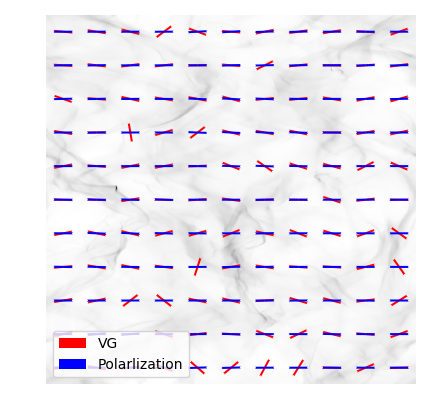

PyObject <matplotlib.legend.Legend object at 0x7f58fe96d390>

In [5]:
imshow(I,cmap="binary")
Xd,Yd=np.meshgrid(div(bs,2):bs:size(I)[2],div(bs,2):bs:size(I)[1]);
quiver(Xd,Yd,cos(Bcna[:]),sin(Bcna[:]),headwidth=0,color="r",label="B field predicted by VGT");
quiver(Xd,Yd,-cos(Bcna[:]),-sin(Bcna[:]),headwidth=0,color="r")
quiver(Xd,Yd,cos(Bpna[:]),sin(Bpna[:]),headwidth=0,color="b",label="Projected B");
quiver(Xd,Yd,-cos(Bpna[:]),-sin(Bpna[:]),headwidth=0,color="b")
title("The comparsion between the VGT method and Projected B field direction")
axis("off");
legend(loc=3)